In [112]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("NLP").getOrCreate()

In [113]:
df = spark.read.csv("./data/raw/DataSet_Emails.csv", header=True, inferSchema=True, multiLine=True, escape='"')


In [114]:
df.count()

31716

In [115]:
df.describe().show()

+-------+-----------------+------------------+--------------------+------------------+----------+--------------------+--------------------+
|summary|              _c0|        message_id|                text|             label|label_text|             subject|             message|
+-------+-----------------+------------------+--------------------+------------------+----------+--------------------+--------------------+
|  count|            31716|             31716|               31665|             31716|     31716|               31442|               31371|
|   mean|          15857.5|16854.187539412284|                NULL|0.5096165973010468|      NULL|            386429.0|            71403.25|
| stddev|9155.764905238666| 9734.616391716854|                NULL|0.4999153936875302|      NULL|  481877.22667086066|   136659.2035841348|
|    min|                0|                 0| ( b  $ b ! zck...|                 0|       ham|                ( b| & who wants to ...|
|    max|           

In [116]:
df.select("_c0").tail(5)

[Row(_c0=31711),
 Row(_c0=31712),
 Row(_c0=31713),
 Row(_c0=31714),
 Row(_c0=31715)]

In [117]:
df = df.drop("_c0")

In [118]:
df.describe().show()

+-------+------------------+--------------------+------------------+----------+--------------------+--------------------+
|summary|        message_id|                text|             label|label_text|             subject|             message|
+-------+------------------+--------------------+------------------+----------+--------------------+--------------------+
|  count|             31716|               31665|             31716|     31716|               31442|               31371|
|   mean|16854.187539412284|                NULL|0.5096165973010468|      NULL|            386429.0|            71403.25|
| stddev| 9734.616391716854|                NULL|0.4999153936875302|      NULL|  481877.22667086066|   136659.2035841348|
|    min|                 0| ( b  $ b ! zck...|                 0|       ham|                ( b| & who wants to ...|
|    max|             33715|þquieres felicita...|                 1|      spam|þquieres felicita...|þya planeó dónde ...|
+-------+---------------

In [119]:
df.groupBy("label_text").count().show()

+----------+-----+
|label_text|count|
+----------+-----+
|       ham|15553|
|      spam|16163|
+----------+-----+



Check For duplicates


In [120]:
df.groupBy(df.columns).count().where("count > 1").show()


+----------+----+-----+----------+-------+-------+----+-----+
|message_id|text|label|label_text|subject|message|date|count|
+----------+----+-----+----------+-------+-------+----+-----+
+----------+----+-----+----------+-------+-------+----+-----+



In [121]:
df_c = df
cc = df_c.count() - df_c.dropDuplicates().count()
print(cc)


0


No duplicates found

check for null values

In [122]:
from pyspark.sql.functions import col,sum
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+----------+----+-----+----------+-------+-------+----+
|message_id|text|label|label_text|subject|message|date|
+----------+----+-----+----------+-------+-------+----+
|         0|  51|    0|         0|    274|    345|   0|
+----------+----+-----+----------+-------+-------+----+



In [123]:
df.printSchema()

root
 |-- message_id: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- date: date (nullable = true)



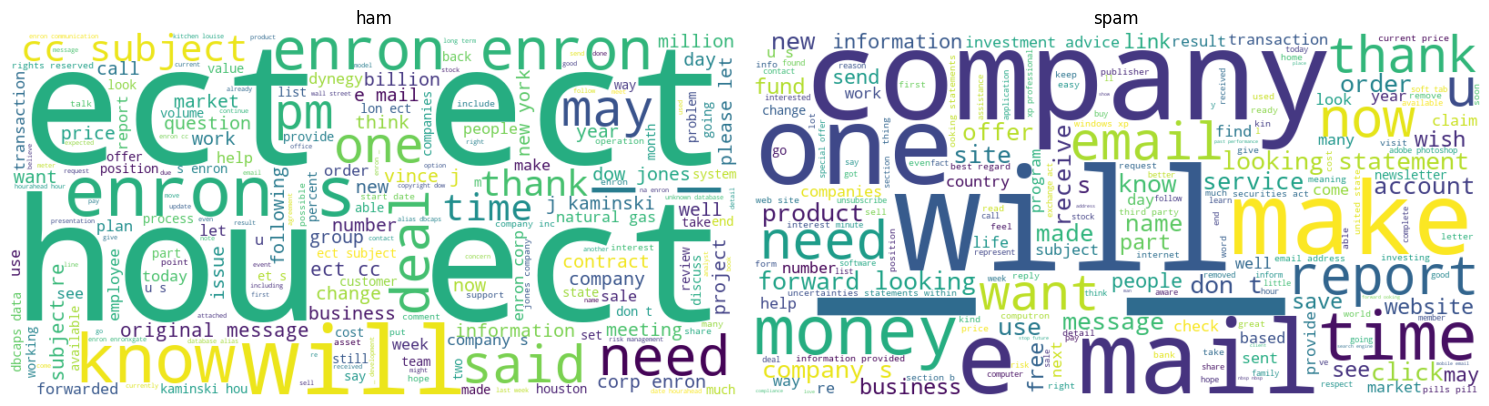

In [124]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_col = "text" 
label_col = "label_text"

labels = df.select(label_col).distinct().toPandas()[label_col].tolist()

plt.figure(figsize=(15, 6))

for i, label in enumerate(labels, 1):
    pdf = (
        df.filter(df[label_col] == label)
          .select(text_col)
          .toPandas()[text_col]
          .dropna()
          .astype(str)
    )
    
    text = " ".join(pdf)

    wc = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.subplot(1, len(labels), i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"{label}")
    
plt.tight_layout()
plt.show()


In [125]:
df.printSchema()

root
 |-- message_id: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- date: date (nullable = true)



In [126]:
df = df.drop("message_id")

In [127]:
df.show(5)

+--------------------+-----+----------+--------------------+--------------------+----------+
|                text|label|label_text|             subject|             message|      date|
+--------------------+-----+----------+--------------------+--------------------+----------+
|any software just...|    1|      spam|any software just...|understanding oem...|2005-06-18|
|perspective on fe...|    0|       ham|perspective on fe...|19 th , 2 : 00 pm...|2001-06-19|
|wanted to try ci ...|    1|      spam|wanted to try ci ...|viagra at $ 1 . 1...|2004-09-11|
|enron / hpl actua...|    0|       ham|enron / hpl actua...|teco tap 30 . 000...|2000-12-12|
|looking for cheap...|    1|      spam|looking for cheap...|water past also ,...|2005-02-13|
+--------------------+-----+----------+--------------------+--------------------+----------+
only showing top 5 rows


In [128]:
from pyspark.sql.functions import lower
df = df.withColumn("text", lower(col("text")))
df = df.withColumn("label_text", lower(col("label_text")))


In [129]:
df = df.drop("subject","message","date")

In [130]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+----+-----+----------+
|text|label|label_text|
+----+-----+----------+
|  51|    0|         0|
+----+-----+----------+



In [131]:
df = df.dropna()

In [132]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+----+-----+----------+
|text|label|label_text|
+----+-----+----------+
|   0|    0|         0|
+----+-----+----------+



In [133]:
from pyspark.sql import functions as F, types as T
df = df.withColumn("text", F.regexp_replace("text", "[^a-z0-9\\s]", " "))


In [134]:
df = df.withColumn("text", F.regexp_replace("text", "\\s+", " "))


In [135]:
df = df.dropDuplicates()


In [136]:
duplicates_count = df.groupBy("text") \
                     .count() \
                     .filter(col("count") > 1) \
                     .agg({"count": "sum"}) \
                     .collect()[0][0]

print(f"Nombre de doublons basés sur 'text': {duplicates_count}")

Nombre de doublons basés sur 'text': None


In [137]:
df = df.filter(F.col("text").isNotNull() & (F.length(F.trim("text")) > 0))


In [138]:
df = df.drop("label_text")

In [ ]:

import nltk
from pyspark.sql import SparkSession, functions as F, types as T
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Transformerx
from pyspark.ml.param.shared import Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql import functions as F

In [140]:
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")



In [141]:

from custom_transformers import StemmerTransformer

In [142]:

stemmer_tf = StemmerTransformer(inputCol="filtered_tokens", outputCol="stemmed")
count_vec = CountVectorizer(inputCol="stemmed", outputCol="features", vocabSize=50000, minDF=5)
classifier = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100)

pipeline = Pipeline(stages=[
    tokenizer,
    remover,
    stemmer_tf,
    count_vec,
    classifier
])


In [143]:
df.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)



In [144]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
train_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|11051|
|    0|11771|
+-----+-----+



In [145]:
model = pipeline.fit(train_df)


In [146]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
preds = model.transform(test_df)
acc = MulticlassClassificationEvaluator(metricName="accuracy").evaluate(preds)
f1 = MulticlassClassificationEvaluator(metricName="f1").evaluate(preds)
print("Accuracy:", acc, "F1:", f1)

Accuracy: 0.979343220338983 F1: 0.9793446523321463


In [147]:
model.write().overwrite().save("../models/pipeline_model")
print("Pipeline sauvegardé ")

Pipeline sauvegardé 
